In [1]:
%matplotlib inline
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from data import *
from vimco_gmm import *
from plots import *
import sys
import time
import datetime
sys.path.append('/home/hao/Research/probtorch/')
from torch.distributions.uniform import Uniform
from torch.distributions.normal import Normal
import probtorch
from probtorch.util import expand_inputs

print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 1.0.0 cuda: True


In [33]:
T = 30
D = 2
K = 3

NUM_OBS = D + K
NUM_SAMPLES = 20
mcmc_steps = 8
## Model Parameters
NUM_HIDDEN = 128
NUM_LATENT = D * K
BATCH_SIZE = 20
NUM_EPOCHS = 1000
LEARNING_RATE = 1e-4
CUDA = False

In [34]:
Ys = np.load('gmm_dataset/sequences.npy')
Zs_true = np.load('gmm_dataset/states.npy')
mu_ks = torch.from_numpy(np.load('gmm_dataset/means.npy')).float()
cov_ks = torch.from_numpy(np.load('gmm_dataset/covariances.npy')).float()
Pi = torch.from_numpy(np.load('gmm_dataset/init.npy')).float()
prior = initial_trans_prior(K)

num_seqs = Ys.shape[0]

Ys_Zs = np.concatenate((Ys, Zs_true), axis=-1)

In [14]:
class Encoder(nn.Module):
    def __init__(self, num_obs=NUM_OBS,
                       num_hidden=NUM_HIDDEN,
                       num_latents=NUM_LATENT):
        super(self.__class__, self).__init__()
        self.enc_hidden = nn.Sequential(
            nn.Linear(num_obs, num_hidden),
            nn.Tanh())
        self.latent_mean = nn.Sequential(
            nn.Linear(num_hidden, num_latents))
        self.latent_log_std = nn.Sequential(
            nn.Linear(num_hidden, num_latents))
        
    def forward(self, obs, T, K, batch_size):
        hidden = self.enc_hidden(obs)
        mean = self.latent_mean(hidden).view(batch_size, T, D*K).mean(1).view(batch_size, K, D)
        std = torch.exp(self.latent_log_std(hidden).view(batch_size, T, D*K)).mean(1).view(batch_size, K, D)
        
        mus = Normal(mean, std).sample()
        return mean, std, mus

In [15]:
def initialize():
    enc = Encoder()
    if CUDA:
        enc.cuda()
    optimizer =  torch.optim.Adam(list(enc.parameters()),lr=LEARNING_RATE)    
    return enc, optimizer
enc, optimizer = initialize()

In [16]:
ELBOs = []
ESSs = []
KLs = []
Grads = []
Sigmas = cov_ks.unsqueeze(0).repeat(BATCH_SIZE, 1, 1)
Grad_Steps = int((Ys.shape[0] / BATCH_SIZE))
for epoch in range(NUM_EPOCHS):
    np.random.shuffle(Ys_Zs)
#     indices = torch.randperm(num_seqs)
    Ys_shuffled = torch.from_numpy(Ys_Zs[:, :, :2]).float()
    Zs_true_shuffled = torch.from_numpy(Ys_Zs[:, :, 2:]).float()
    for step in range(Grad_Steps):
        time_start = time.time()
        optimizer.zero_grad()
        batch_data = Ys_shuffled[step*BATCH_SIZE : (step+1)*BATCH_SIZE]
        batch_zs = Zs_true_shuffled[step*BATCH_SIZE : (step+1)*BATCH_SIZE]
        gradient, elbo = ag_mcmc_vimco_gmm(enc, batch_zs, Pi, Sigmas, batch_data, T, D, K, NUM_SAMPLES, mcmc_steps, BATCH_SIZE)
        loss = - gradient
        loss.backward()
        optimizer.step()
        ELBOs.append(elbo.item())
#         ESSs.append(ess.item())
#         KLs.append(kl.item())
        Grads.append(loss.item())
        time_end = time.time()
        print('epoch : %d, step : %d, ELBO : %f (%ds)' % (epoch, step, elbo, time_end - time_start))

epoch : 0, step : 0, ELBO : -444.579773 (1s)
epoch : 0, step : 1, ELBO : -436.633301 (2s)
epoch : 0, step : 2, ELBO : -427.570129 (2s)
epoch : 0, step : 3, ELBO : -438.713867 (2s)
epoch : 0, step : 4, ELBO : -436.323578 (2s)
epoch : 1, step : 0, ELBO : -451.925537 (2s)
epoch : 1, step : 1, ELBO : -432.009674 (2s)
epoch : 1, step : 2, ELBO : -426.779877 (2s)
epoch : 1, step : 3, ELBO : -435.082520 (2s)
epoch : 1, step : 4, ELBO : -441.145752 (2s)
epoch : 2, step : 0, ELBO : -443.420013 (2s)
epoch : 2, step : 1, ELBO : -439.580017 (1s)
epoch : 2, step : 2, ELBO : -436.349274 (2s)
epoch : 2, step : 3, ELBO : -437.794525 (2s)
epoch : 2, step : 4, ELBO : -448.020996 (1s)
epoch : 3, step : 0, ELBO : -432.342621 (1s)
epoch : 3, step : 1, ELBO : -440.753174 (2s)
epoch : 3, step : 2, ELBO : -445.339447 (1s)
epoch : 3, step : 3, ELBO : -438.662201 (1s)
epoch : 3, step : 4, ELBO : -444.031097 (1s)
epoch : 4, step : 0, ELBO : -438.757812 (2s)
epoch : 4, step : 1, ELBO : -433.810211 (2s)
epoch : 4,

KeyboardInterrupt: 

In [81]:
BATCH_SIZE = 10
Ys_test = torch.from_numpy(Ys[:BATCH_SIZE, :]).float()
Zs_test = torch.from_numpy(Zs_true[:BATCH_SIZE, :]).float()
mu_ks = torch.from_numpy(np.load('gmm_dataset/means.npy')).float()[:BATCH_SIZE]
Sigmas = cov_ks.unsqueeze(0).repeat(BATCH_SIZE, 1, 1)

In [90]:
Zs_candidates = torch.zeros((NUM_SAMPLES, BATCH_SIZE, T, K)).float()
mcmc_steps = 20
for m in range(mcmc_steps):
    if m == 0:
        for l in range(NUM_SAMPLES):
            mus, log_p_init = init_mus(K, D, BATCH_SIZE)
       
            Z, log_qz = E_step_gmm(mus, Sigmas, Ys_test, T, D, K)
            Zs_candidates[l] = Z
            ## the first incremental weight is just log normalizer since As is sampled from prior
    else:
        for l in range(NUM_SAMPLES):
            Ys_Z = torch.cat((Ys_test, Zs_candidates[l]), -1)
            mean, std, mus = enc(Ys_Z, T, K, BATCH_SIZE)
            ## Sigmas needs to be B-K-D
            Z, log_qz = E_step_gmm(mus, Sigmas, Ys_test, T, D, K)
            Zs_candidates[l] = Z

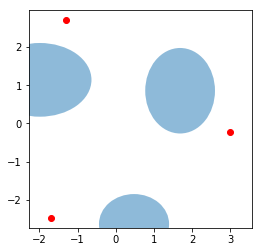

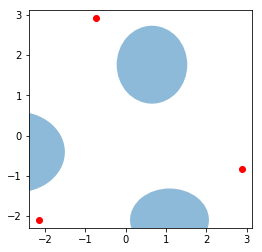

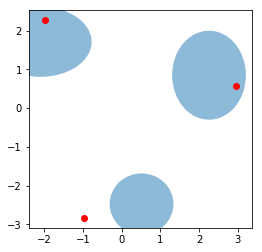

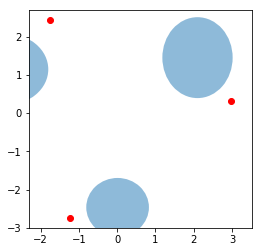

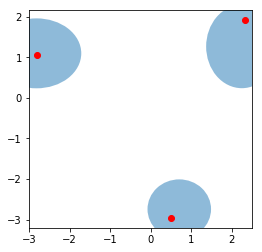

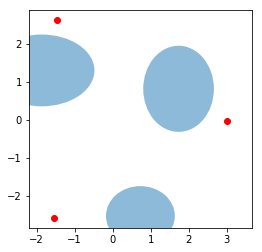

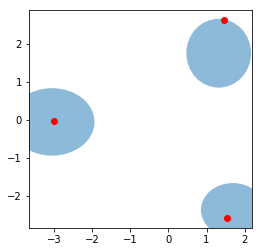

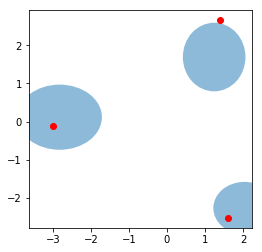

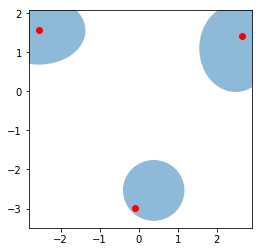

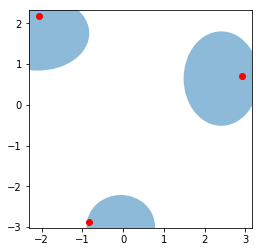

In [91]:
for b in range(BATCH_SIZE):
    mu = mean.data.numpy()[b]
    sigma = torch.zeros((K, D, D)).float()
    for k in range(K):
        sigma[k] = torch.diag(std[b, k])
    sigma = sigma.data.numpy()
    plot_clusters(mu_ks[b].data.numpy(), mu, sigma, K)
    plt.show()

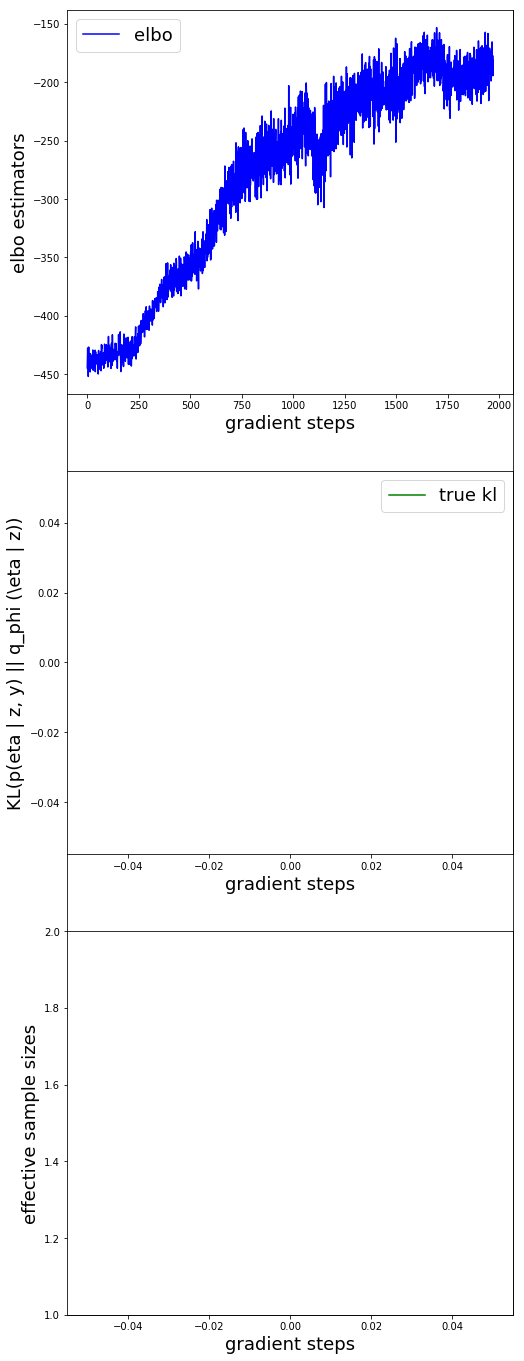

In [17]:
def plot_results(ELBOs, ESSs, KLs, filename):
    fig, ax = plt.subplots(figsize=(8,24))
    ax.set_xticks([])
    ax.set_yticks([])
    ax1 = fig.add_subplot(3,1,1)
    ax1.plot(ELBOs, 'b-', label='elbo')
    ax1.legend(fontsize=18)
    ax1.set_xlabel('gradient steps', fontsize=18)
    ax1.set_ylabel('elbo estimators', fontsize=18)
    ax2 = fig.add_subplot(3,1,2)
    ax2.plot(KLs, 'g-', label='true kl')
    ax2.set_xlabel('gradient steps', fontsize=18)
    ax2.set_ylabel('KL(p(eta | z, y) || q_phi (\eta | z))', fontsize=18)
    ax2.legend(fontsize=18)
    ax3 = fig.add_subplot(3,1,3)
    ax3.plot(ESSs, 'm-o')
    ax3.set_xlabel('gradient steps', fontsize=18)
    ax3.set_ylabel('effective sample sizes', fontsize=18)
    ax3.set_ylim([1, 2])
    plt.savefig(filename)
plot_results(ELBOs, ESSs, KLs, 'results_sis.png')